# Enefit - Predict Energy Behavior of Prosumers

This project is a contribution to the kaggle competition from Enefit, where the goal is to create an energy predictive model of prosumers to reduce energy imbalance costs. This is a supervised learning approach where the data provided to train the models contains labels/values, it is a regression since the target variable is continous, more specifically it is a time series problem because we have previous measurements of energy produced and consumed and it is expected to predict the future patterns of these data.

The escalating population of prosumers underscores the urgency to address issues related to energy imbalance and escalating costs. Failing to tackle these challenges may result in heightened operational expenses, potential grid instability, and inefficient utilization of energy resources. Effectively resolving this predicament would substantially diminish imbalance costs, enhance grid reliability, and optimize the integration of prosumers into the energy system, fostering efficiency and sustainability. Additionally, a successful resolution has the potential to incentivize more consumers to transition to prosumers, assured that their energy behavior can be effectively managed. This, in turn, promotes renewable energy production and utilization.

## Data Source
Kristjn Eljand, Martin Laid, Jean-Baptiste Scellier, Sohier Dane, Maggie Demkin, Addison Howard. (2023). Enefit - Predict Energy Behavior of Prosumers. Kaggle. https://kaggle.com/competitions/predict-energy-behavior-of-prosumers

In [1]:
import os
import gc
import pickle

import numpy as np
import pandas as pd
import polars as pl

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)

# Data Cleaning

This work leverages [@greysky's](https://www.kaggle.com/greysky) work on pre-processing the data and providing an example on how to submit to the competition in his notebook [Enefit Generic Notebook](https://www.kaggle.com/code/greysky/enefit-generic-notebook/notebook). Their code is properly identified at the start and end of each code block.

This data cleaning effort mostly consists in joining multiple tables together by their appropiate identifier, on the right date.

In [2]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
def feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target):
    df_data = (
        df_data
        .with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )
    )
    
    df_client = (
        df_client
        .with_columns(
            (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
        )
    )
    
    df_gas = (
        df_gas
        .rename({"forecast_date": "date"})
        .with_columns(
            (pl.col("date") + pl.duration(days=1)).cast(pl.Date)
        )
    )
    
    df_electricity = (
        df_electricity
        .rename({"forecast_date": "datetime"})
        .with_columns(
            pl.col("datetime") + pl.duration(days=1)
        )
    )
    
    df_location = (
        df_location
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32)
        )
    )
    
    df_forecast = (
        df_forecast
        .rename({"forecast_datetime": "datetime"})
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
            pl.col('datetime').dt.convert_time_zone("Europe/Bucharest").dt.replace_time_zone(None).cast(pl.Datetime("us")),
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
    )
    
    df_historical = (
        df_historical
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
            pl.col("datetime") + pl.duration(hours=37)
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
    )
    
    df_forecast_date = (
        df_forecast
        .group_by("datetime").mean()
        .drop("county")
    )
    
    df_forecast_local = (
        df_forecast
        .filter(pl.col("county").is_not_null())
        .group_by("county", "datetime").mean()
    )
    
    df_historical_date = (
        df_historical
        .group_by("datetime").mean()
        .drop("county")
    )
    
    df_historical_local = (
        df_historical
        .filter(pl.col("county").is_not_null())
        .group_by("county", "datetime").mean()
    )
    
    df_data = (
        df_data
        .join(df_gas, on="date", how="left")
        .join(df_client, on=["county", "is_business", "product_type", "date"], how="left")
        .join(df_electricity, on="datetime", how="left")
        
        .join(df_forecast_date, on="datetime", how="left", suffix="_fd")
        .join(df_forecast_local, on=["county", "datetime"], how="left", suffix="_fl")
        .join(df_historical_date, on="datetime", how="left", suffix="_hd")
        .join(df_historical_local, on=["county", "datetime"], how="left", suffix="_hl")
        
        .join(df_forecast_date.with_columns(pl.col("datetime") + pl.duration(days=7)), 
              on="datetime", how="left", suffix="_fdw")
        .join(df_forecast_local.with_columns(pl.col("datetime") + pl.duration(days=7)), 
              on=["county", "datetime"], how="left", suffix="_flw")
        .join(df_historical_date.with_columns(pl.col("datetime") + pl.duration(days=7)), 
              on="datetime", how="left", suffix="_hdw")
        .join(df_historical_local.with_columns(pl.col("datetime") + pl.duration(days=7)), 
              on=["county", "datetime"], how="left", suffix="_hlw")
        
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=2))
              .rename({"target": "target_1"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=3))
              .rename({"target": "target_2"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=4))
              .rename({"target": "target_3"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=5))
              .rename({"target": "target_4"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=6))
              .rename({"target": "target_5"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=7))
              .rename({"target": "target_6"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=14))
              .rename({"target": "target_7"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        
        .with_columns(
            pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
            pl.col("datetime").dt.hour().alias("hour"),
            pl.col("datetime").dt.day().alias("day"),
            pl.col("datetime").dt.weekday().alias("weekday"),
            pl.col("datetime").dt.month().alias("month"),
            pl.col("datetime").dt.year().alias("year"),
        )
        
        .with_columns(
            pl.concat_str("county", "is_business", "product_type", "is_consumption", separator="_").alias("category_1"),
        )
        
        .with_columns(
            (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
            (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
            (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
            (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
        )
        
        .with_columns(
            pl.col(pl.Float64).cast(pl.Float32),
        )
        
        .drop("date", "datetime", "hour", "dayofyear")
    )
    
    return df_data
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

In [3]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
def to_pandas(X, y=None):
    cat_cols = ["county", "is_business", "product_type", "is_consumption", "category_1"]
    
    if y is not None:
        df = pd.concat([X.to_pandas(), y.to_pandas()], axis=1)
    else:
        df = X.to_pandas()    
    
    df = df.set_index("row_id")
    df[cat_cols] = df[cat_cols].astype("category")
    
    df["target_mean"] = df[[f"target_{i}" for i in range(1, 7)]].mean(1)
    df["target_std"] = df[[f"target_{i}" for i in range(1, 7)]].std(1)
    df["target_ratio"] = df["target_6"] / (df["target_7"] + 1e-3)
    
    return df
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

In [4]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
def lgb_objective(trial):
    params = {
        'n_iter'           : 1000,
        'verbose'          : -1,
        'random_state'     : 42,
        'objective'        : 'l2',
        'learning_rate'    : trial.suggest_float('learning_rate', 0.01, 0.1),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bynode' : trial.suggest_float('colsample_bynode', 0.5, 1.0),
        'lambda_l1'        : trial.suggest_float('lambda_l1', 1e-2, 10.0),
        'lambda_l2'        : trial.suggest_float('lambda_l2', 1e-2, 10.0),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 4, 256),
        'max_depth'        : trial.suggest_int('max_depth', 5, 10),
        'max_bin'          : trial.suggest_int('max_bin', 32, 1024),
    }
    
    model  = lgb.LGBMRegressor(**params)
    X, y   = df_train.drop(columns=["target"]), df_train["target"]
    cv     = MonthlyKFold(1)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    
    return -1 * np.mean(scores)
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

### Global Variables

In [5]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
root = "/kaggle/input/predict-energy-behavior-of-prosumers"

data_cols        = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
client_cols      = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols         = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols    = ['latitude', 'longitude', 'hours_ahead', 'temperature', 'dewpoint', 'cloudcover_high', 
                    'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', 
                    '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 
                    'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
historical_cols  = ['datetime', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure','cloudcover_total',
                    'cloudcover_low','cloudcover_mid','cloudcover_high','windspeed_10m','winddirection_10m',
                    'shortwave_radiation','direct_solar_radiation','diffuse_radiation','latitude','longitude']
location_cols    = ['longitude', 'latitude', 'county']
target_cols      = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime']

save_path = None
load_path = None
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

### Data I/O

In [6]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
df_data        = pl.read_csv(os.path.join(root, "train.csv"), columns=data_cols, try_parse_dates=True)
df_client      = pl.read_csv(os.path.join(root, "client.csv"), columns=client_cols, try_parse_dates=True)
df_gas         = pl.read_csv(os.path.join(root, "gas_prices.csv"), columns=gas_cols, try_parse_dates=True)
df_electricity = pl.read_csv(os.path.join(root, "electricity_prices.csv"), columns=electricity_cols, try_parse_dates=True)
df_forecast    = pl.read_csv(os.path.join(root, "forecast_weather.csv"), columns=forecast_cols, try_parse_dates=True)
df_historical  = pl.read_csv(os.path.join(root, "historical_weather.csv"), columns=historical_cols, try_parse_dates=True)
df_location    = pl.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"), columns=location_cols, try_parse_dates=True)
df_target      = df_data.select(target_cols)

schema_data        = df_data.schema
schema_client      = df_client.schema
schema_gas         = df_gas.schema
schema_electricity = df_electricity.schema
schema_forecast    = df_forecast.schema
schema_historical  = df_historical.schema
schema_target      = df_target.schema
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

### Feature Engineering

In [7]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
X, y = df_data.drop("target"), df_data.select("target")

X = feature_eng(X, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target)

df_train = to_pandas(X, y)
df_train = df_train[df_train["target"].notnull()]
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

# EDA

As shown below 2,017,824 observations are available in our train set. These data come from different sources clearly conscise in a single table with 137 variables. Here there is a description of the most important variables:

* is_business - Boolean for whether or not the prosumer is a business.
* product_type - ID code with the following mapping of codes to contract types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.
* target - The consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type.
* is_consumption - Boolean for whether or not this row's target is consumption or production.

In [8]:
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2017824 entries, 0 to 2018351
Data columns (total 137 columns):
 #    Column                                 Dtype   
---   ------                                 -----   
 0    county                                 category
 1    is_business                            category
 2    product_type                           category
 3    is_consumption                         category
 4    lowest_price_per_mwh                   float32 
 5    highest_price_per_mwh                  float32 
 6    eic_count                              float64 
 7    installed_capacity                     float32 
 8    euros_per_mwh                          float32 
 9    hours_ahead                            float32 
 10   temperature                            float32 
 11   dewpoint                               float32 
 12   cloudcover_high                        float32 
 13   cloudcover_low                         float32 
 14   cloudcover_mid       

1. The first step is to sample the data, +2M rows is too much for a computer to process quickly and it is ideal to pivot fast between plots and processing. The following process generates a sample dataset of 278,136 rows to work with.

In [11]:
# Sample size per group
sample_size = 10

# List of variables for which you want to sample data
variables_to_sample = ["county", "is_business", "product_type", "is_consumption", "month", "year"]

# Group by the specified variables and sample data from each group
sample_df = df_train.groupby(variables_to_sample, group_keys=True).apply(lambda x: x.sample(min(len(x), sample_size)))

# Resetting the index of the sampled data
sample_df = sample_df.reset_index(drop=True)

# Now, 'sampled_data' contains a representative sample based on the specified variables
sample_df.shape[0]

27820

Some transformations were applied to faciliate the visualizations:

In [12]:
sample_df['log_target'] = np.log(sample_df['target']+1)
sample_df['installed_capacity_sq'] = sample_df['installed_capacity']**2
sample_df['is_consumption'] = np.where(sample_df['is_consumption'] == 1, 'Consumption', 'Production')
sample_df['product_type'] = np.where(sample_df['product_type'] == 0, 'Combined', sample_df['product_type'])
sample_df['product_type'] = np.where(sample_df['product_type'] == '1', 'Fixed', sample_df['product_type'])
sample_df['product_type'] = np.where(sample_df['product_type'] == '2', 'General service', sample_df['product_type'])
sample_df['product_type'] = np.where(sample_df['product_type'] == '3', 'Spot', sample_df['product_type'])

## The response variable

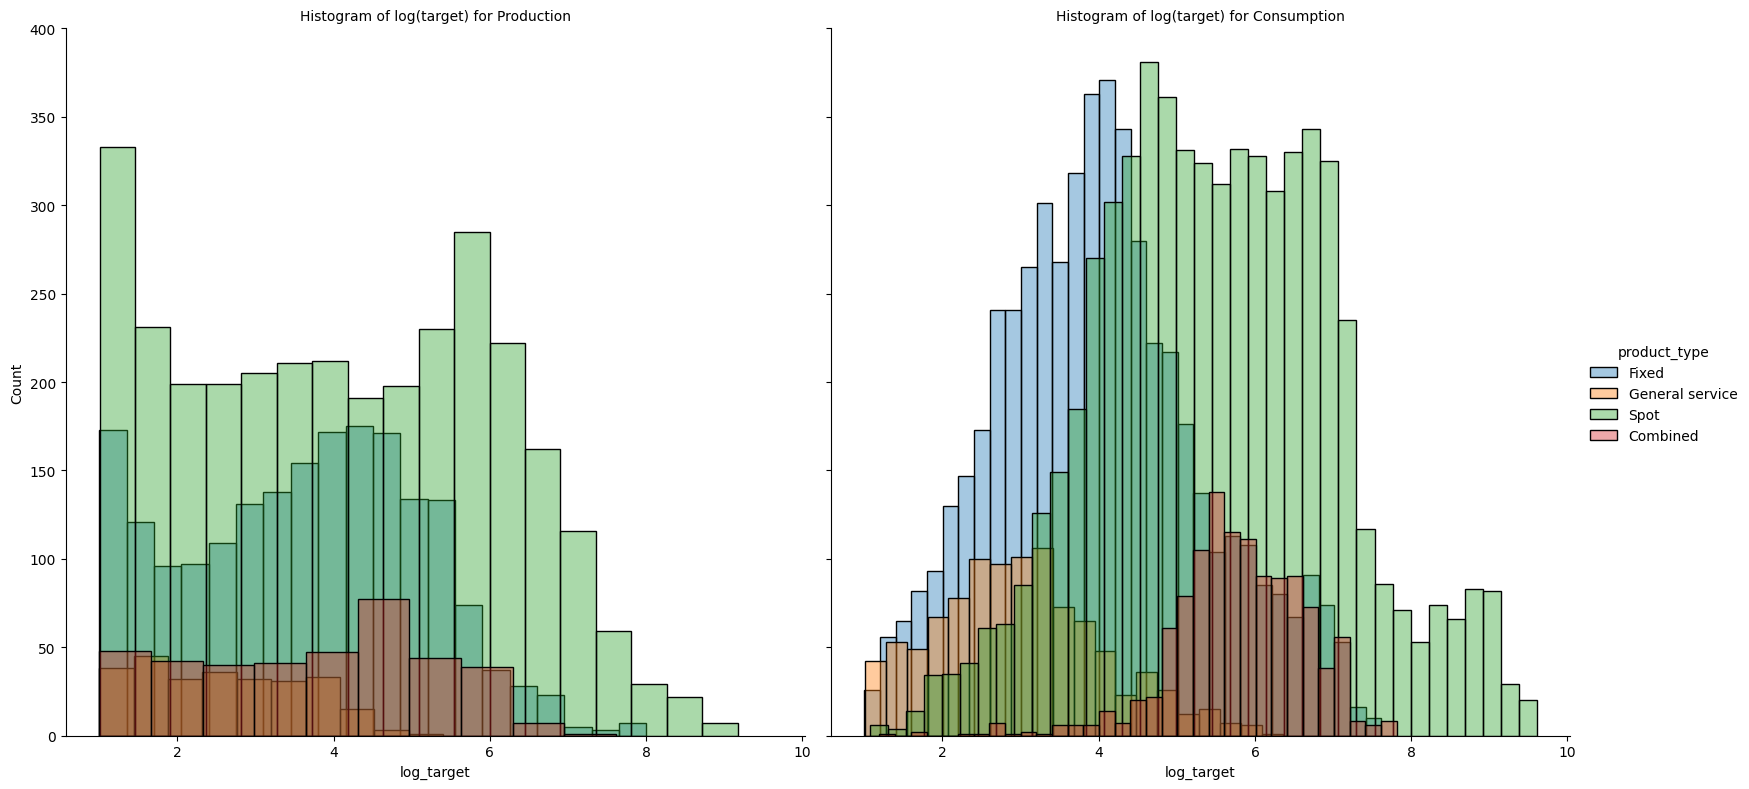

In [13]:
# Set the default figure size for all subsequent plots
plt.rcParams['figure.figsize'] = (10, 8)

# Create a FacetGrid with two columns, one for each binomial variable
g = sns.FacetGrid(sample_df[sample_df['log_target'].gt(1)], col='is_consumption', hue='product_type', height=8, aspect=1)

# Map a scatter plot onto the grid
g.map(sns.histplot, 'log_target', alpha=0.4)
g.add_legend()
# Set labels and title for each subplot
g.set_titles('Histogram of log(target) for {col_name}')

Notice the different distributions among Production and Consumption, this may hint a benefit of using different models for each pattern. Even diving deeper into product_type. From this we split our sample data into consumption/production.

In [14]:
sample_pro = sample_df[sample_df['is_consumption']=='Production']
sample_con = sample_df[sample_df['is_consumption']=='Consumption']
print(sample_pro.shape[0], sample_con.shape[0])

13910 13910


### Correlation matrices

An interesting finding, by separating the production and consumption patterns we discover even more correlations in the production side. It is observed that the comsupmtion target positively correlates with lagged target data stronger than in the production target.

In [15]:
def corr_heatmap(df, title):
    num_cols = df.columns[df.dtypes == 'float32']
    corr_mat = df[[*num_cols, 'log_target']].corr()
    filt_corr_mat = corr_mat[np.abs(corr_mat['log_target']) > 0.15]
    filt_corr_mat = filt_corr_mat[filt_corr_mat.index]
    mask = np.triu(np.ones_like(filt_corr_mat, dtype=bool))
    sns.heatmap(filt_corr_mat, cmap='coolwarm', mask=mask, linewidths=.5, center=0)
    plt.title(f'{title} Correlation Heatmap (abs > 0.15)')
    return filt_corr_mat.index

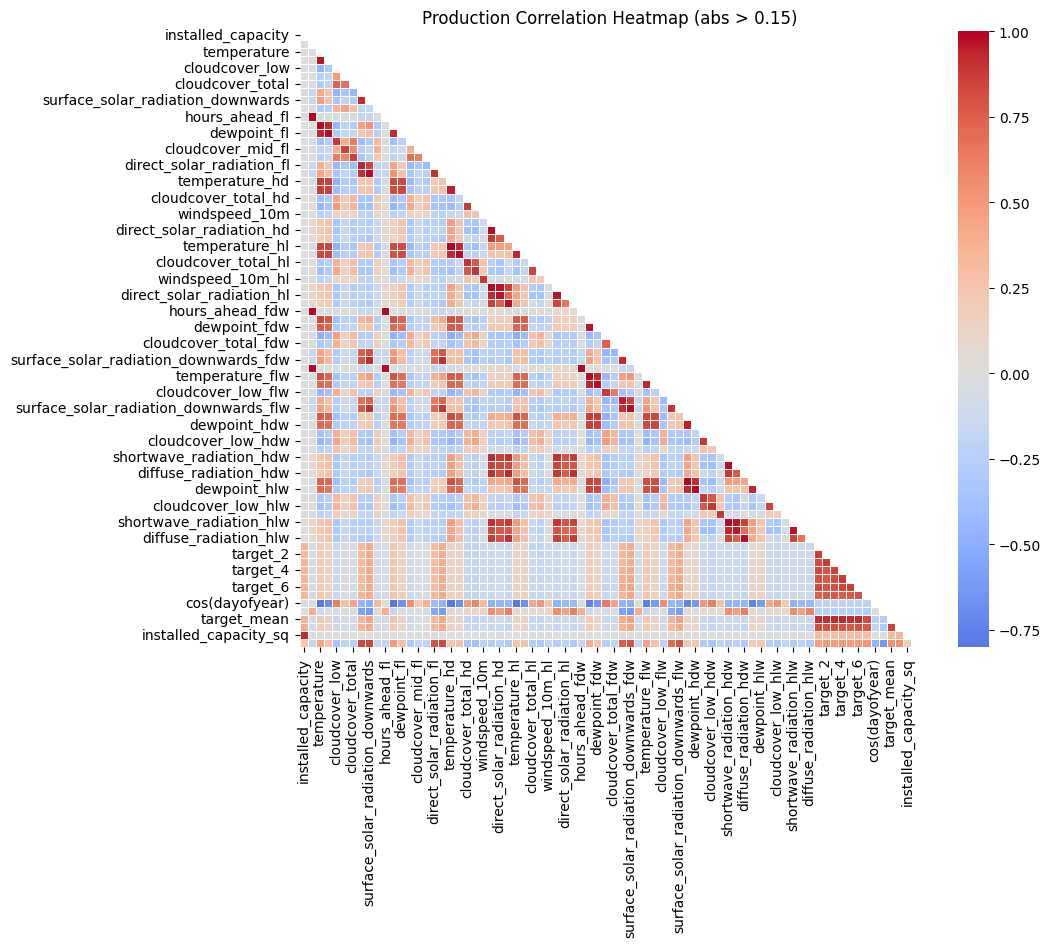

In [16]:
prod_cols = corr_heatmap(sample_pro, 'Production')

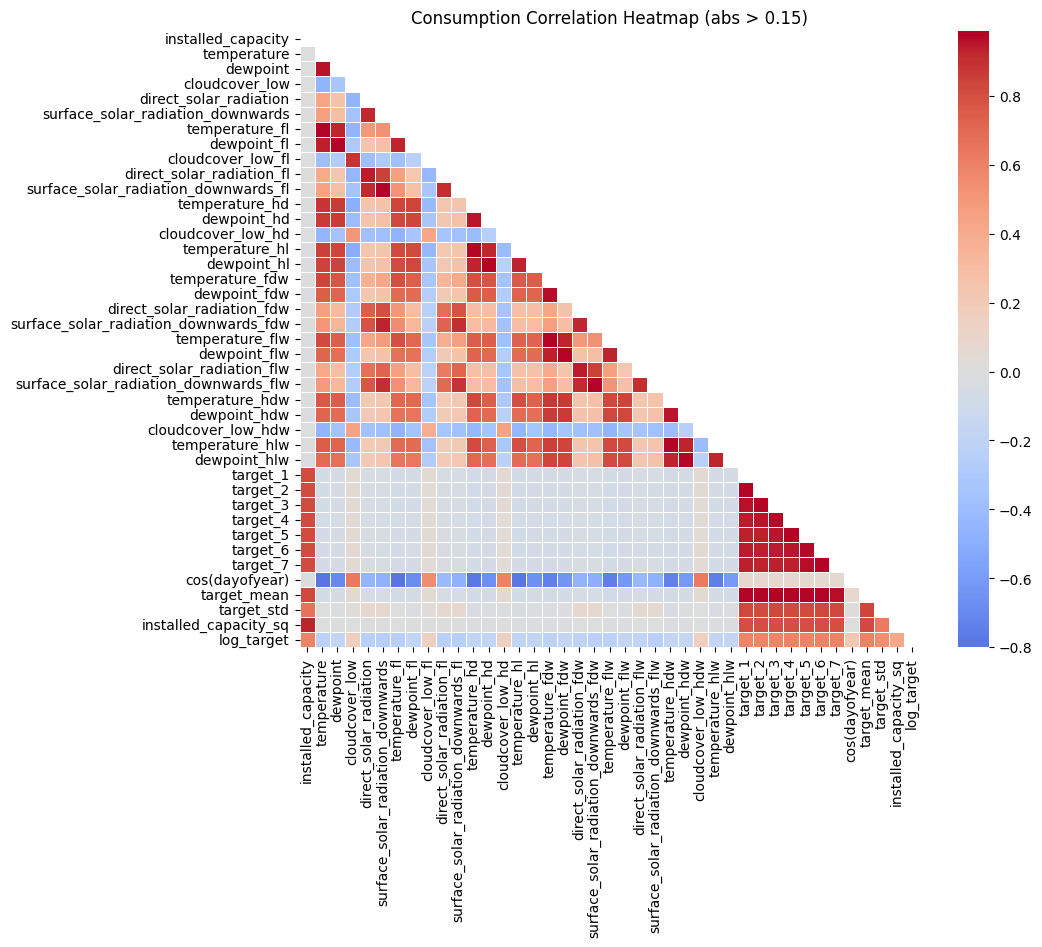

In [17]:
con_cols = corr_heatmap(sample_con, 'Consumption')

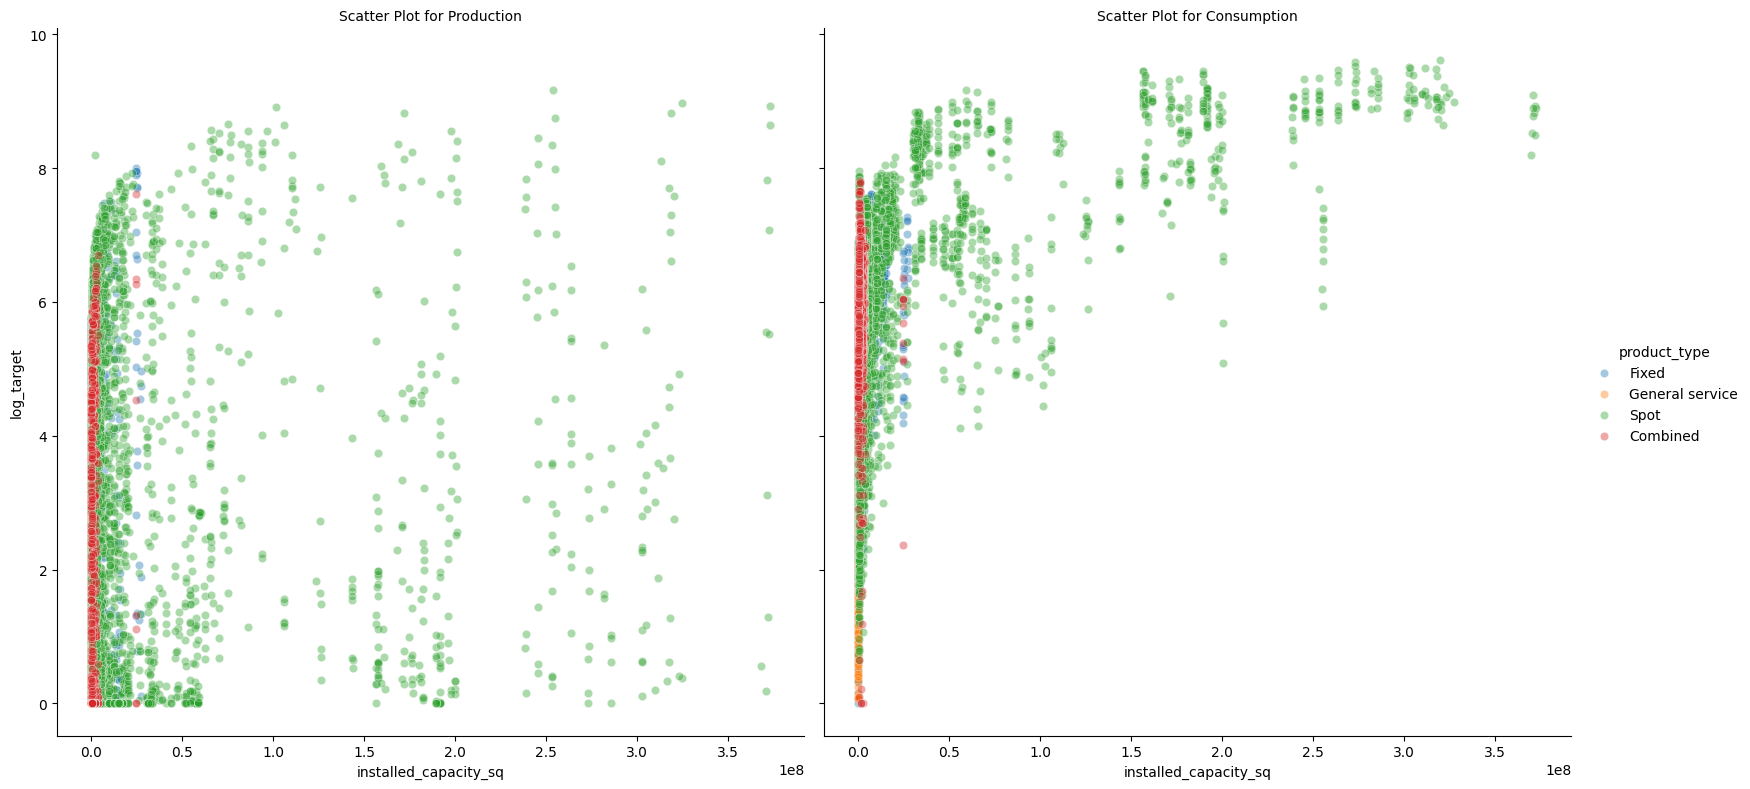

In [18]:
# Set the default figure size for all subsequent plots
plt.rcParams['figure.figsize'] = (10, 8)

# Create a FacetGrid with two columns, one for each binomial variable
g = sns.FacetGrid(sample_df, col='is_consumption', hue='product_type', height=8, aspect=1)

# Map a scatter plot onto the grid
g.map(sns.scatterplot, 'installed_capacity_sq', 'log_target', alpha=0.4)
g.add_legend()
# Set labels and title for each subplot
g.set_titles('Scatter Plot for {col_name}')

# Models

Missing to select the prod_cols for the prod validation.

In [19]:
%time
df_train['log_target'] = np.log(df_train['target']+1)
df_train['installed_capacity_sq'] = df_train['installed_capacity']**2

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 22.9 µs


In [33]:
sample_train = sample_df[sample_df[[*con_cols, 'is_consumption', 'county']].notnull()]

In [34]:
sample_train = sample_train[[*con_cols, 'is_consumption', 'county']].dropna()

In [35]:
consumption_train = sample_train[sample_train['is_consumption'] == 'Consumption']
consumption_train.shape

(13226, 43)

In [64]:
production_train = sample_train[sample_train['is_consumption'] == 'Production']
production_train.shape

(13191, 43)

In [53]:
from sklearn import tree
clf = tree.DecisionTreeRegressor(criterion='absolute_error')


In [62]:
from sklearn.model_selection import cross_validate
scoring = ['neg_mean_absolute_error']
clf = tree.DecisionTreeRegressor(criterion='absolute_error')
scores = cross_validate(clf, consumption_train.drop(columns=["log_target",'county', 'is_consumption']), 
                consumption_train["log_target"], cv=3, scoring=scoring)
scores

{'fit_time': array([14.67469239, 14.60928535, 14.89267397]),
 'score_time': array([0.00521159, 0.00524807, 0.00515103]),
 'test_neg_mean_absolute_error': array([-0.3091943 , -0.32078779, -0.32683524])}

In [65]:
scoring = ['neg_mean_absolute_error']
clf = tree.DecisionTreeRegressor(criterion='absolute_error')
scores = cross_validate(clf, production_train.drop(columns=["log_target",'county', 'is_consumption']), 
                production_train["log_target"], cv=3, scoring=scoring)
scores

In [66]:
scores

{'fit_time': array([27.43416786, 22.91070056, 34.00474095]),
 'score_time': array([0.00537205, 0.00520492, 0.00544262]),
 'test_neg_mean_absolute_error': array([-0.40492145, -0.37536392, -0.43932899])}

In [63]:
np.exp(-scores['test_neg_mean_absolute_error'])

array([1.36232704, 1.37821307, 1.38657301])

In [61]:
np.exp(-scores['test_neg_mean_absolute_error'])

array([1.53702217, 1.49869256, 1.5515091 ])

In [49]:
val = cross_val_score(clf, 
                sample_train.drop(columns=["log_target",'county', 'is_consumption']), 
                sample_train["log_target"], 
                scoring='neg_mean_absolute_error', 
                cv=3)

ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 1247, in fit
    super().fit(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of DecisionTreeRegressor must be a str among {'squared_error', 'friedman_mse', 'poisson', 'absolute_error'}. Got 'absolute_eror' instead.


In [52]:
type(val)

numpy.ndarray

In [47]:
np.exp(sample_train['log_target']).describe()

count    26417.000000
mean       279.352612
std        923.659411
min          1.000000
25%          1.368000
50%         33.335000
75%        179.574000
max      14883.329000
Name: log_target, dtype: float64

In [50]:
np.exp(-val)


array([1.53310455, 1.49020504, 1.5455372 ])

In [38]:
%time
rf_reg = RandomForestRegressor(random_state=1)
# cross_val_score(rf_reg, X, y, scoring='neg_mean_absolute_error', cv=3)
rf = rf_reg.fit(X=sample_train.drop(columns=["log_target",'county','is_consumption']),
        y=sample_train["log_target"])
%time

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11.4 µs


### HyperParam Optimization

In [ ]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
best_params = {
    'n_iter'           : 900,
    'verbose'          : -1,
    'objective'        : 'l2',
    'learning_rate'    : 0.05689066836106983,
    'colsample_bytree' : 0.8915976762048253,
    'colsample_bynode' : 0.5942203285139224,
    'lambda_l1'        : 3.6277555139102864,
    'lambda_l2'        : 1.6591278779517808,
    'min_data_in_leaf' : 186,
    'max_depth'        : 9,
    'max_bin'          : 813,
} # val score is 62.24 for the last month
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

### Validation

In [ ]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
'''result = cross_validate(
    estimator=lgb.LGBMRegressor(**best_params, random_state=42),
    X=df_train.drop(columns=["target"]), 
    y=df_train["target"],
    scoring="neg_mean_absolute_error",
    cv=MonthlyKFold(1),
)

print(f"Fit Time(s): {result['fit_time'].mean():.3f}")
print(f"Score Time(s): {result['score_time'].mean():.3f}")
print(f"Error(MAE): {-result['test_score'].mean():.3f}")'''
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

### Training

In [ ]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
if load_path is not None:
    model = pickle.load(open(load_path, "rb"))
else:
    model = VotingRegressor([
        ('lgb_1', lgb.LGBMRegressor(**best_params, random_state=100)), 
        ('lgb_2', lgb.LGBMRegressor(**best_params, random_state=101)), 
        ('lgb_3', lgb.LGBMRegressor(**best_params, random_state=102)), 
        ('lgb_4', lgb.LGBMRegressor(**best_params, random_state=103)), 
        ('lgb_5', lgb.LGBMRegressor(**best_params, random_state=104)), 
    ])
    
    model.fit(
        X=df_train.drop(columns=["target"]),
        y=df_train["target"]
    )

if save_path is not None:
    with open(save_path, "wb") as f:
        pickle.dump(model, f)
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

### Prediction

In [ ]:
import enefit

env = enefit.make_env()
iter_test = env.iter_test()

In [ ]:
for (test, revealed_targets, client, historical_weather,
        forecast_weather, electricity_prices, gas_prices, sample_prediction) in iter_test:
    
    test = test.rename(columns={"prediction_datetime": "datetime"})
    
    df_test           = pl.from_pandas(test[data_cols[1:]], schema_overrides=schema_data)
    df_client         = pl.from_pandas(client[client_cols], schema_overrides=schema_client)
    df_gas            = pl.from_pandas(gas_prices[gas_cols], schema_overrides=schema_gas)
    df_electricity    = pl.from_pandas(electricity_prices[electricity_cols], schema_overrides=schema_electricity)
    df_new_forecast   = pl.from_pandas(forecast_weather[forecast_cols], schema_overrides=schema_forecast)
    df_new_historical = pl.from_pandas(historical_weather[historical_cols], schema_overrides=schema_historical)
    df_new_target     = pl.from_pandas(revealed_targets[target_cols], schema_overrides=schema_target)
    
    df_forecast       = pl.concat([df_forecast, df_new_forecast]).unique()
    df_historical     = pl.concat([df_historical, df_new_historical]).unique()
    df_target         = pl.concat([df_target, df_new_target]).unique()
    
    X_test = feature_eng(df_test, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target)
    X_test = to_pandas(X_test)
    
    sample_prediction["target"] = model.predict(X_test).clip(0)
    
    env.predict(sample_prediction)